In [1]:
import torch
from torch import nn

# default: d_model=768, nhead=12, num_layers=12
encoder_layer = nn.TransformerEncoderLayer(d_model=768, nhead=8)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)

p_model = nn.Sequential(
    transformer_encoder,
    nn.Linear(768, 2),
    nn.Softmax(dim=2)
)

c_model = nn.Sequential(
    transformer_encoder,
    nn.Linear(768, 7),
    nn.Softmax(dim=2)
)


/home/nick/school/csc420/final/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [2]:
p_checkpoint = torch.load('person_model-epoch6.pt', map_location=torch.device('cpu'))

p_model.load_state_dict(p_checkpoint['model_state_dict'])

<All keys matched successfully>

In [4]:
# PhotoData class
from typing import Tuple
import h5py
import numpy as np


class PhotoData(object):

    SRC_FOLDER = 'images/'

    LBL_FOLDER = 'labels/'

    HDF5_FILE = 'all_images.h5'

    N = 600

    def indextofilename(index) -> str:
        return f"{index:04d}.jpg"
    
    def indextolabelname(index) -> Tuple[str]:
        ind = f"{index:04d}"
        return f"{ind}_person.png", f"{ind}_clothes.png"


    def loadimages(self):
        images = np.ndarray((PhotoData.N, 600, 400, 3))
        for i in range(PhotoData.N):
            img_url = os.path.join(PhotoData.SRC_FOLDER, PhotoData.indextofilename(i + 1))
            im = iio.imread(img_url)
            images[i] = im
        return images
    
    def loadlabels(self):
        p_labels = np.ndarray((PhotoData.N, 600, 400), dtype=bool)
        c_labels = np.ndarray((PhotoData.N, 600, 400), dtype=np.int8)

        for i in range(PhotoData.N):
            p_name, c_name = PhotoData.indextolabelname(i+1)
            p_url = os.path.join(PhotoData.LBL_FOLDER, p_name)
            c_url = os.path.join(PhotoData.LBL_FOLDER, c_name)
            p_im = iio.imread(p_url)
            c_im = iio.imread(c_url)
            p_labels[i] = p_im[:,:,0] > 0
            # https://stackoverflow.com/questions/15635025/how-to-map-false-color-image-to-specific-labels-assigned-for-each-color
            r_channel = c_im[:, :, 0] > 0
            g_channel = c_im[:, :, 1] > 0
            b_channel = c_im[:, :, 2] > 0
            labels = (b_channel << 2) + (g_channel << 1) + r_channel
            c_labels[i] = labels
        return p_labels, c_labels
    
    def parsedata(self):
        images = self.loadimages()
        p_labels, c_labels = self.loadlabels()
        return images, p_labels, c_labels

    def storeh5(self, images, p_labels, c_labels):
        file = h5py.File(PhotoData.HDF5_FILE, 'w')
        file.create_dataset('images', np.shape(images), h5py.h5t.STD_U8BE, data=images)
        file.create_dataset('person_labels', np.shape(p_labels), h5py.h5t.STD_U8BE, data=p_labels)
        file.create_dataset('clothing_labels', np.shape(c_labels), h5py.h5t.STD_U8BE, data=c_labels)
        file.close()

    def loadh5(self):
        images, p_labels, c_labels = [], [], []
        file = h5py.File(PhotoData.HDF5_FILE, 'r+')
        images = np.array(file['images']).astype('uint8')
        p_labels = np.array(file['person_labels']).astype('float32')
        c_labels = np.array(file['clothing_labels']).astype('float32')
        return images, p_labels, c_labels

In [5]:
data = PhotoData()
imgs, _, _ = data.loadh5()
test_src = torch.tensor(imgs[360:], dtype=torch.float32)
test_src.shape

torch.Size([240, 950, 768])

In [6]:
p_model.eval()

n_test = 10

p_output = p_model(test_src[:n_test])
p_output.shape

torch.Size([10, 950, 2])

In [16]:
c_checkpoint = torch.load('clothes_model-epoch6.pt', map_location=torch.device('cpu'))
c_model.load_state_dict(c_checkpoint['model_state_dict'])
c_model.eval()
c_output = c_model(test_src[:n_test])
c_output.shape

torch.Size([10, 950, 7])

# Compare Results

In [7]:
from IPython.display import Image

## Person Model

In [17]:
top_k = torch.topk(p_output, 1).indices
height = 38
width = 25
out_to_im = (top_k * 255).reshape((n_test, height, width))


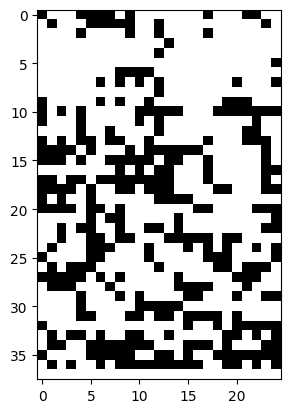

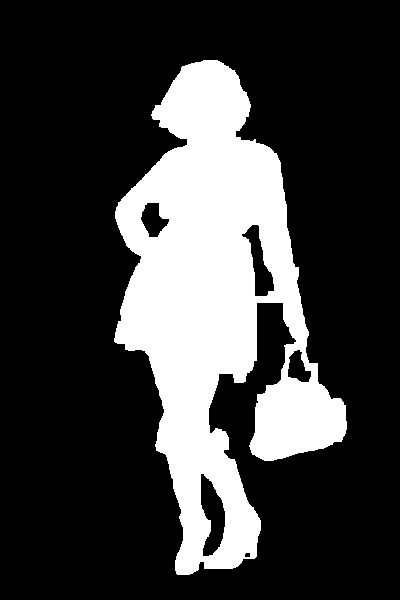

In [13]:
i = 1
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(out_to_im[i], interpolation='nearest')
plt.show()
Image(filename=f"labels/{(361+i):04d}_clothes.png")

## Clothing Comparison

In [46]:
def k_to_color(labels):
    """
    Convert top-1 indices to their corresponding colors

    labels: NxHxWx1
    """
    N, H, W, _ = labels.shape
    out_im = np.zeros((N, H, W, 0), dtype=np.byte)
    r = np.left_shift(labels & 1, 7)
    g = np.left_shift(labels & 2, 6)
    b = np.left_shift(labels & 4, 5)
    out_im = np.append(out_im, r, axis=3)
    out_im = np.append(out_im, g, axis=3)
    out_im = np.append(out_im, b, axis=3)
    return out_im

In [49]:
top_k = torch.topk(c_output, 1).indices
height = 38
width = 25
reshaped_out = top_k.reshape((n_test, height, width, 1))
out_im = k_to_color(reshaped_out)

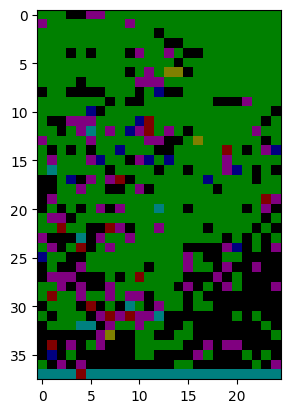

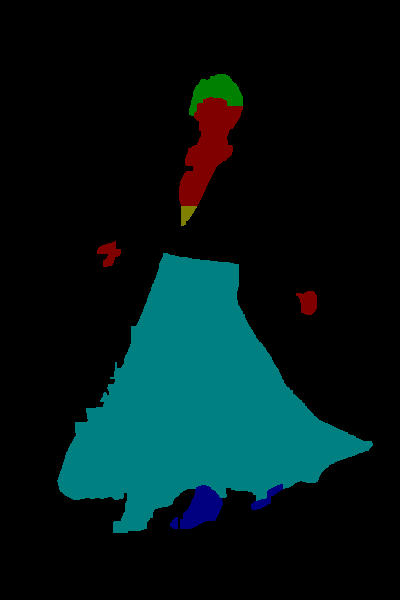

In [52]:
i = 4
plt.set_cmap('Accent')
plt.imshow(out_im[i], interpolation='nearest')
plt.show()
Image(filename=f"labels/{(361+i):04d}_clothes.png")